# Semantic Segmentation on Indian Driving Dataset

## 1. Business Problem

### 1.1. Problem Overview

- Most of the datasets for autonomous navigation tend to focus on structured driving environments. This usually corresponds to well-delineated infrastructures such as lanes, a small number of well-deﬁned categories for traﬃc participants, low variation  in an object or background appearance, and strong adherence to traﬃc rules.
- Indian Driving Dataset (IDD) is a collection of autonomous driving annotated street-level images captured on Indian roads, and formatted to facilitate use for the purpose of training AI systems and neural networks. It consists of images from unstructured environments where the above assumptions are largely not satisfied. It reflects label distributions of road scenes significantly different from existing datasets, with most classes displaying greater within-class diversity. Consistent with real driving behaviors, it also identifies new classes such as drivable areas besides the road.
- It is difficult to completely avoid ambiguity between some labels. For example labels like parking, caravan, or trailer cannot be precisely defined due to the diversity of the scenes and vehicles in the data collected. For resolving this issue, the dataset is designed as a 4 level label hierarchy having 7 (level 1), 16 (level 2), 26 (level 3), and 30 (level 4) labels.
- The images are obtained from a front-facing camera attached to a car. The car was driven around Hyderabad, Bangalore cities and their outskirts. <br> <br>
Source - http://idd.insaan.iiit.ac.in/


### 1.2 Data

- There are 1403 train images, 204 validation images and 404 test images
- Shape of the input image and segmentation masks given: [227,320,3]
- Shape of the output segmentation mask expected: [256,128]
<br> <br>
Source - http://idd.insaan.iiit.ac.in/dataset/download/

### 1.3 Challenge

- The idd20k_lite dataset has 7 classes that include Drivable, Non-Drivable, Living things, Vehicles, Road-side objects, Far-objects, and Sky.
- The segmentation challenge is the pixel-level prediction of all the 7 classes at level 1 of the label hierarchy.
- The predictions are supposed to be png images, with the size of 256x128. Each pixel of this image contains the label as level1Ids (see labels code [here](https://github.com/AutoNUE/public-code/blob/312a6ba2219a39fe8b105e44ad0612079249bad8/helpers/anue_labels.py#L40)) of the corresponding image (resized to 256x128). The evaluation code resizes both your prediction and ground truth png files to 256x128, in case they are not of that size.
<br><br> Source - http://idd.insaan.iiit.ac.in/evaluation/ncv19-leader-board/

### 1.4 Performance Metric

- mIoU <br><br>
The performance metric is Mean-Intersection-Over-Union (mIoU). mIoU is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes.


In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip tar file with original images
import tarfile
fname = '/content/drive/MyDrive/idd-lite.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [ ]:
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.17.0


## Loading the Dataset

In [ ]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42

# Dataset path
dataset_path = '/content/idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

## Data Visualization

### Sample Training Image

### Plotting the image

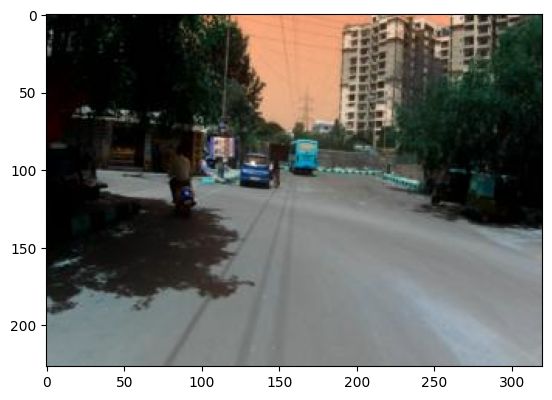

In [ ]:
# Reading a sample image and plotting it
img = cv2.imread(img_train+'29/972458_image.jpg',1)
plt.imshow(img)

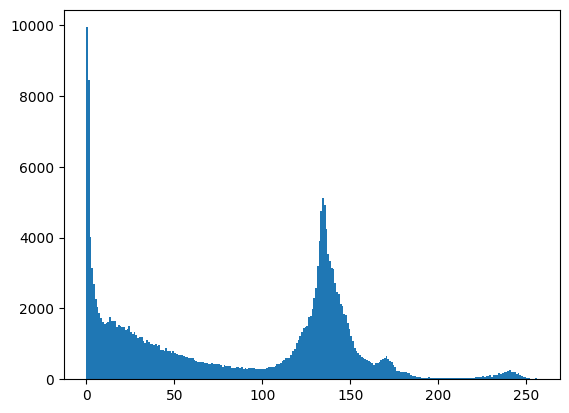

In [ ]:
# Plotting an Histogram to find the frequency of pixel intensity values.
plt.hist(img.ravel(),256,[0,256])
plt.show()

<b> From the above histogram plot, we get the distribution of the pixel intensity values in the given image. </b>

### Annotated Images

<b> What is Image Annotation? </b>

It is a process of labeling the data (available in the format of images), to make the object in the image recognizable to machines through computer vision technology. Basically, its used to detect, classify and group the objects in machine learning training.

### Plotting the given annotated image

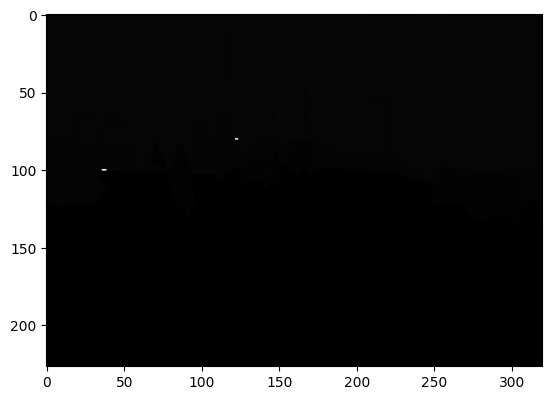

In [ ]:
# Reading the given annotated image for the above sample image
img = cv2.imread(seg_train+'29/972458_label.png',1)
plt.imshow(img)

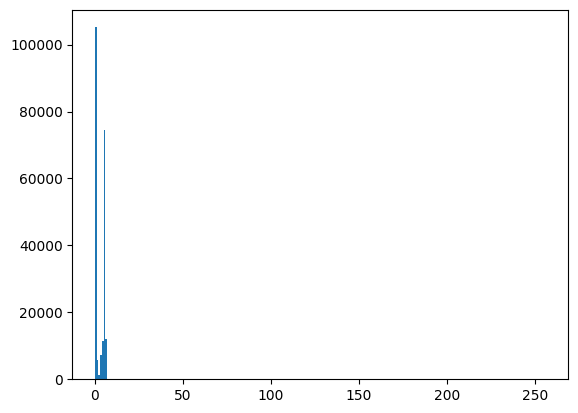

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img.ravel(),256,[0,256])
plt.show()

In [ ]:
# Frequency Distribution
# This is to find the exact number of pixels corresponind to each class
y = np.bincount(img.flatten())
ii = np.nonzero(y)[0]
np.vstack((ii, y[ii])).T

array([[     0, 105186],
       [     1,   5832],
       [     2,   1416],
       [     3,   7371],
       [     4,  11481],
       [     5,  74550],
       [     6,  12069],
       [   255,     15]])

<b> We can observe that, in the annotated image, all of the pixel intensity values are from 0-6 and there are some pixels of the value 255. So, let's get a closer look to the plot in the range 0-6. </b>

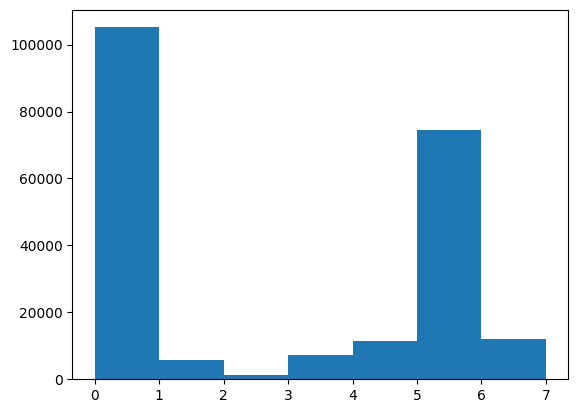

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img.ravel(),7,[0,7])
plt.show()

<b> So, in the given annotated image, all the pixels (excluding the pixel value 255) are from the range 0-6 (for 7 classes). We can intensify these pixels to get clearer annotations, as with a wider range of pixels, it will be easier to distinguish between the pixels as colors vary on a wider range. We will multiply each pixel, excluding 0 and 255 with 40, so we will get different colors with a difference of larger values. </b>

### Plotting the annotated image after intensifying the pixels

In [ ]:
# This function visualizes the segmenetation image by multiplying each pixel with 40
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def visualizeSegmentationImages(imagepath):
    img_seg = cv2.imread(imagepath,0)
    # We are going to loop through all the pixel values and multiply them by 40 now
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j] != 0 or img_seg[i][j] != 255:
                # max value will be 6*40=240 which is under 255
                img_seg[i][j] *= 40
    return img_seg

In [ ]:
# Getting the processed segmentation image for visualization
img_seg = visualizeSegmentationImages(seg_train+'29/972458_label.png')

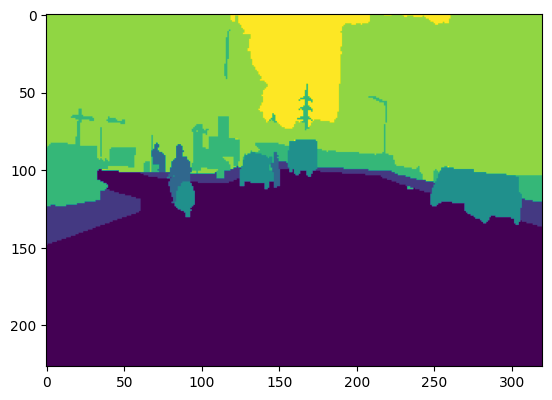

In [ ]:
# Plotting the processed segmentation image
plt.imshow(img_seg)

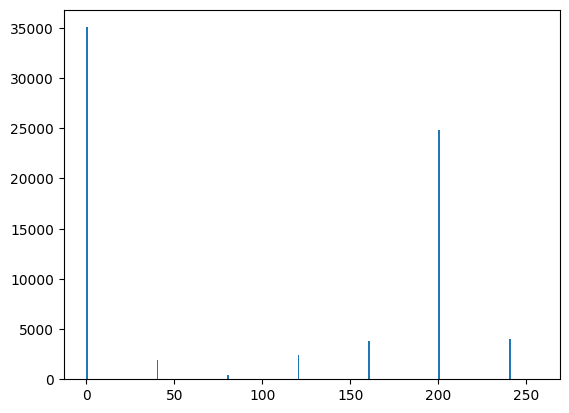

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img_seg.ravel(),256,[0,256])
plt.show()

<b> Now, we can easily distinguish the objects after intensifying the pixels as there are colors vary on a wider range, so it is easy to visualize the annotated image. </b>

## Data Preparation

<b>References </b> <br>
https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/ <br>
https://www.tensorflow.org/tutorials/load_data/images <br>
https://www.tensorflow.org/tutorials/images/segmentation

In [ ]:
# Image size that we are going to use
(HEIGHT,WIDTH) = (128,256)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 8

In [ ]:
# Reference -> https://docs.python.org/2/library/glob.html
# The glob module finds all the pathnames matching a specified pattern according to
# the rules used by the Unix shell, although results are returned in arbitrary order.

TRAINSET_SIZE = len(glob(img_train+'*/*_image.jpg'))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(img_val+'*/*_image.jpg'))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 1403 images.
The Validation Dataset contains 204 images.


In [ ]:
def parse_image(img_path):
    """
    Load an image and its annotation (mask) and returning a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # For one Image path:
    # .../idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path is:
    # .../idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    # Reading the annotation file corresponding the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files
# tf.data.Dataset.list_files returns a dataset of all files matching one or more glob patterns.

train_dataset = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
val_dataset = val_dataset.map(parse_image)

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/cast
# Returns a Tensor same shape as given tensor and same type as dtype that is mentioned.

def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/image/resize
# Resize images to the size specified

def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask



In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
dataset = {"train": train_dataset, "val": val_dataset}

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Preparing the Train dataset by applying dataset transformations
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

# Preparing the Validation Dataset
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>


In [ ]:
def prepare_for_training(datapoint): # Change the function signature to accept a dictionary
    # Access image and mask directly from datapoint
    input_image = datapoint['image']
    input_mask = datapoint['segmentation_mask']
    # Create a dictionary from the image and mask
    datapoint = {'image': input_image, 'segmentation_mask': input_mask}
    return load_image_train(datapoint) # Call load_image_train with the dictionary

**NEW model**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, Dropout, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def ASPP(x, num_filters):
    # Atrous Spatial Pyramid Pooling (ASPP) for capturing multi-scale context
    shape = tf.keras.backend.int_shape(x)

    y1 = Conv2D(num_filters, 1, padding="same")(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)

    y2 = Conv2D(num_filters, 3, padding="same", dilation_rate=6)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(num_filters, 3, padding="same", dilation_rate=12)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(num_filters, 3, padding="same", dilation_rate=18)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # Global Average Pooling and upsample
    y5 = GlobalAveragePooling2D()(x)
    y5 = Reshape((1, 1, shape[-1]))(y5)  # Reshape to match the input dimensions
    y5 = Conv2D(num_filters, 1, padding="same")(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    y5 = UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(y5)

    # Concatenate all the different scale outputs
    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(num_filters, 1, padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def DeepLabV3Plus(input_shape=(128, 256, 3), num_classes=8):
    # Input layer
    inputs = Input(shape=input_shape)

    # Backbone (ResNet50 or other backbone)
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # Extract feature maps at different scales
    x = base_model.get_layer("conv4_block6_2_relu").output  # High-level feature
    low_level_feature = base_model.get_layer("conv2_block3_2_relu").output  # Low-level feature

    # Apply ASPP on the high-level feature map
    x = ASPP(x, 256)

    # Upsample the ASPP output to match the size of the low-level feature map
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Reduce the low-level feature map dimensions for concatenation
    low_level_feature = Conv2D(48, 1, padding="same")(low_level_feature)
    low_level_feature = BatchNormalization()(low_level_feature)
    low_level_feature = Activation("relu")(low_level_feature)

    # Concatenate the ASPP output and low-level features
    x = Concatenate()([x, low_level_feature])

    # Further processing
    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    # Upsample to the original image size
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Output layer for semantic segmentation
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

# Compile the model
model = DeepLabV3Plus(input_shape=(128, 256, 3), num_classes=8)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 128, 64)    │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 128, 64)    │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 128, 64)    │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 130, 64)    │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,855,992 (45.23 MB)

 Trainable params: 11,823,256 (45.10 MB)

 Non-trainable params: 32,736 (127.88 KB)

starting the training


In [ ]:
# Constants
EPOCHS = 100  # Number of epochs for training
BATCH_SIZE = 32

# Number of images in the datasets
num_train_images = 1403  # Number of training images
num_val_images = 204     # Number of validation images

# Calculate steps per epoch and validation steps
STEPS_PER_EPOCH = num_train_images // BATCH_SIZE
VALIDATION_STEPS = num_val_images // BATCH_SIZE

# Compile the model with optimized learning rate
initial_lr = 0.001  # Start with this learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(
    dataset['train'],
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=dataset['val'],
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

# Save the best model at the end
model.save('final_model.keras')


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 120s 612ms/step - accuracy: 0.6749 - loss: 0.8766 - val_accuracy: 0.1955 - val_loss: 19604.1895 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 501ms/step - accuracy: 0.8066 - loss: 0.4654 - val_accuracy: 0.4083 - val_loss: 8.1680 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 507ms/step - accuracy: 0.8230 - loss: 0.4164 - val_accuracy: 0.4600 - val_loss: 5.1758 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 495ms/step - accuracy: 0.8327 - loss: 0.3931 - val_accuracy: 0.4465 - val_loss: 2.0939 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - accuracy: 0.8392 - loss: 0.3723 - val_accuracy: 0.4479 - val_loss: 2.2298 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.8504 - loss: 0.3458 - val_accuracy: 0.3697 - val_loss: 3.7255 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accuracy: 0.850

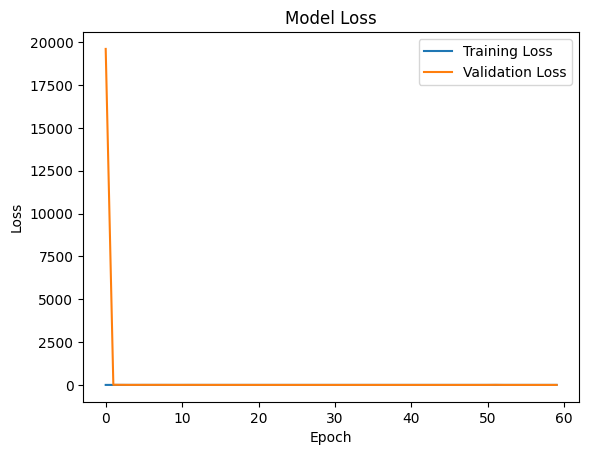

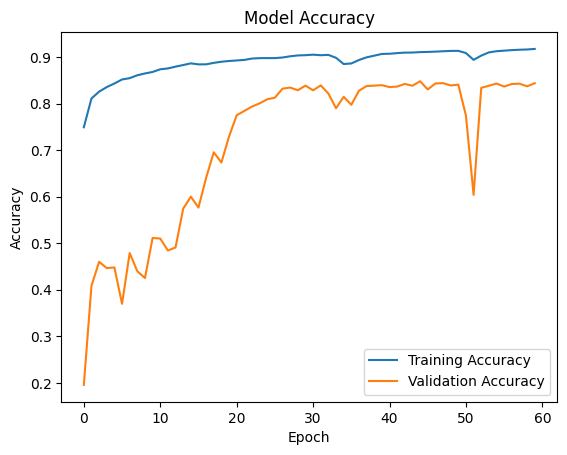

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Evaluating the model on the validation dataset
val_loss, val_accuracy = model.evaluate(dataset['val'], steps=VALSET_SIZE // BATCH_SIZE)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.8418 - loss: 0.4208
Validation Loss: 0.4359779357910156
Validation Accuracy: 0.8402778506278992


In [ ]:
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-q_kkt7yg
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-q_kkt7yg
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405191 sha256=9cfcc87eb60ce9ba81c3ba8fa4565ba6c36847ca5b842205fe3c04a634b129c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8av2lxv/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


**Updated Code with CRF Post-processing**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


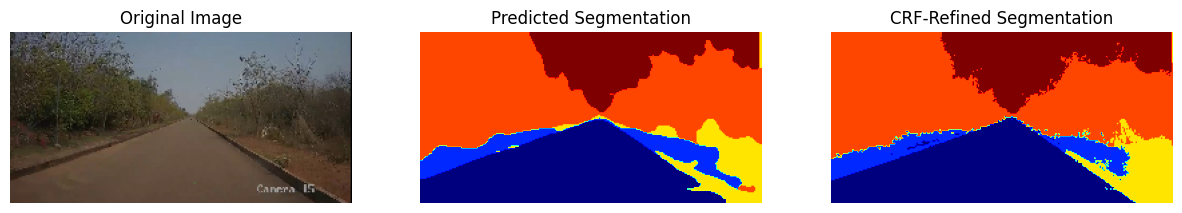

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Function to apply DenseCRF
def apply_crf(original_image, predicted_mask, num_classes):
    h, w = predicted_mask.shape[:2]

    # Ensure the predicted mask is softmax probability (not argmax yet)
    softmax_output = np.transpose(predicted_mask, (2, 0, 1))  # Channels first format
    softmax_output = np.ascontiguousarray(softmax_output)  # Ensure it's C-contiguous

    # Create the unary potential from softmax scores
    unary = unary_from_softmax(softmax_output)

    # Initialize DenseCRF
    d = dcrf.DenseCRF2D(w, h, num_classes)

    # Set the unary energy (negative log likelihood)
    d.setUnaryEnergy(unary)

    # Create pairwise energy from RGB image (bilateral potential)
    pairwise_bilateral = create_pairwise_bilateral(sdims=(10, 10), schan=(13, 13, 13),
                                                   img=original_image, chdim=2)

    # Add pairwise terms to CRF
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Run inference (mean field approximation)
    Q = d.inference(5)

    # Get the most probable class for each pixel
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))

    return refined_mask

# Load your saved model (DeepLabV3+)
model = tf.keras.models.load_model('/content/best_model.keras')

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

# Load and preprocess a sample image
image_path = '/content/drive/MyDrive/my testing images/Screenshot (314) - Copy - Copy.png'
input_shape = (128, 256, 3)  # Assuming this is your input shape
num_classes = 8  # Number of segmentation classes
original_img, img_array = preprocess_image(image_path, target_size=input_shape[:2])

# Predict the mask
prediction = model.predict(img_array)

# Convert the original image and prediction to C-contiguous arrays
contiguous_img = np.ascontiguousarray(np.array(original_img))  # Ensure image is C-contiguous
contiguous_prediction = np.ascontiguousarray(prediction[0])    # Ensure prediction is C-contiguous

# Apply CRF post-processing
refined_mask = apply_crf(contiguous_img, contiguous_prediction, num_classes)  # Apply CRF to the predicted mask

# Function to visualize original, predicted, and CRF-refined masks
def display_segmentation_results(original_img, predicted_mask, refined_mask):
    plt.figure(figsize=(15, 5))

    # Show original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    # Show predicted mask (without CRF)
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(predicted_mask, axis=-1), cmap='jet')
    plt.title('Predicted Segmentation')
    plt.axis('off')

    # Show CRF-refined mask
    plt.subplot(1, 3, 3)
    plt.imshow(refined_mask, cmap='jet')
    plt.title('CRF-Refined Segmentation')
    plt.axis('off')

    plt.show()

# Display the results
display_segmentation_results(original_img, prediction[0], refined_mask)


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Function to apply DenseCRF
def apply_crf(original_image, predicted_mask, num_classes):
    h, w = predicted_mask.shape[:2]

    # Ensure the predicted mask is softmax probability (not argmax yet)
    softmax_output = np.transpose(predicted_mask, (2, 0, 1))  # Channels first format
    softmax_output = np.ascontiguousarray(softmax_output)  # Ensure it's C-contiguous

    # Create the unary potential from softmax scores
    unary = unary_from_softmax(softmax_output)

    # Initialize DenseCRF
    d = dcrf.DenseCRF2D(w, h, num_classes)

    # Set the unary energy (negative log likelihood)
    d.setUnaryEnergy(unary)

    # Create pairwise energy from RGB image (bilateral potential)
    pairwise_bilateral = create_pairwise_bilateral(sdims=(10, 10), schan=(13, 13, 13),
                                                   img=original_image, chdim=2)

    # Add pairwise terms to CRF
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Run inference (mean field approximation)
    Q = d.inference(5)

    # Get the most probable class for each pixel
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))

    return refined_mask

# Load your trained model
model = tf.keras.models.load_model('/content/best_model.keras')



# Function to preprocess a single video frame
def preprocess_frame(frame, target_size):
    # Resize the frame to (128, 256), which is the correct target size (height, width)
    frame_resized = cv2.resize(frame, (target_size[1], target_size[0]))  # Correct the width and height order
    img_array = frame_resized / 255.0  # Normalize the frame
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array, frame_resized


# Process video function
def process_video(video_path, output_path, model, num_classes, target_size=(128, 256)):
    # Load video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define codec and create VideoWriter object for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess frame
        img_array, resized_frame = preprocess_frame(frame, target_size=target_size)

        # Predict the segmentation mask
        prediction = model.predict(img_array)
        predicted_mask = np.argmax(prediction[0], axis=-1)  # Get predicted class per pixel

        # Convert the frame and prediction to C-contiguous arrays
        contiguous_frame = np.ascontiguousarray(resized_frame)  # Ensure frame is C-contiguous
        contiguous_prediction = np.ascontiguousarray(prediction[0])  # Ensure prediction is C-contiguous

        # Apply CRF post-processing
        refined_mask = apply_crf(contiguous_frame, contiguous_prediction, num_classes)

        # Resize refined mask back to the original frame size
        refined_mask_resized = cv2.resize(refined_mask, (frame_width, frame_height), interpolation=cv2.INTER_NEAREST)

        # Colorize the refined mask (apply a colormap for visualization)
        colored_mask = cv2.applyColorMap((refined_mask_resized * (255 // num_classes)).astype(np.uint8), cv2.COLORMAP_JET)

        # Overlay mask on the original frame
        output_frame = cv2.addWeighted(frame, 0.7, colored_mask, 0.3, 0)

        # Write the frame to the output video
        out.write(output_frame)

        frame_count += 1
        print(f"Processed frame {frame_count}")

    # Release resources
    cap.release()
    out.release()
    print(f"Video processing complete. Output saved at {output_path}.")

# Path to the input video and output video
video_path = '/content/drive/MyDrive/cam15_12thMarch.mp4'  # Replace with your video file path
output_path = '/content/output_video_with_crf.mp4'

# Process and save the video
process_video(video_path, output_path, model, num_classes=8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Processed frame 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Processed frame 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Processed frame 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Processed frame 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processed frame 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Processed frame 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processed frame 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processed frame 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Processed frame 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processed frame 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Processed frame 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processed frame 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processed frame 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processed frame 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processed frame 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processed frame 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processed frame 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Proc